<a href="https://colab.research.google.com/github/piyush-an/INFO7374_Predict_StockPrice/blob/main/notebooks/5_Benchmark_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART 5 : Benchmark Study using GARCH or Kalman Filter

In [33]:
%%bash

pip install pandas yfinance

In [34]:
import scipy.stats
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf

In [35]:
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)
NVDA = yf.download("NVDA", start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


## Empirical Distribution

MEAN:  359.83780002993024
SAMPLE STD 106.27360196999261
SKEWNESS:  -0.4374360986816272
KURTOSIS:  -1.3310070208749993
95% confidence interval of bootstrap means: 345.62373505277117 372.9918491890241
95% confidence interval of standard error of means: 6.5044200512794434 7.192182205320233
95% confidence interval of NVDA standard deviation: 100.55589375383808 111.1884386301538


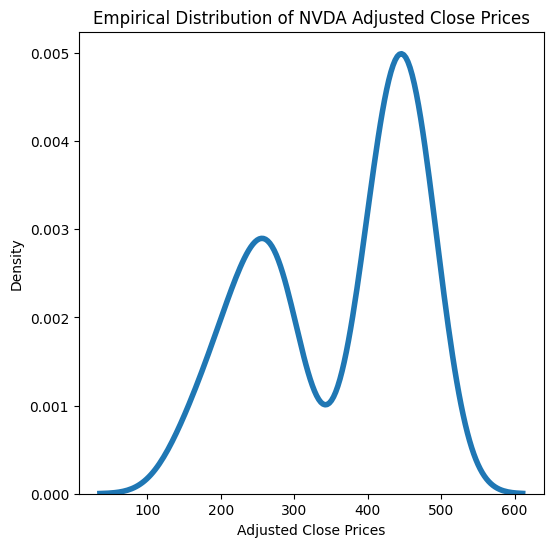

In [36]:
adj_close_prices = NVDA["Adj Close"].values

# Calculate statistical measures
mean_adj_close = np.mean(adj_close_prices)
sample_std = np.std(adj_close_prices)
skewness = scipy.stats.skew(adj_close_prices)
kurtosis = scipy.stats.kurtosis(adj_close_prices)

# Print statistical measures
print("MEAN: ", mean_adj_close)
print("SAMPLE STD", sample_std)
print("SKEWNESS: ", skewness)
print("KURTOSIS: ", kurtosis)

# Plot empirical distribution
plt.figure(figsize=(6, 6))
sns.kdeplot(data=adj_close_prices, linewidth=4)
plt.xlabel("Adjusted Close Prices")
plt.ylabel("Density")
plt.title("Empirical Distribution of NVDA Adjusted Close Prices")

# Bootstrap for confidence intervals
num_samples = adj_close_prices.shape[0]
num_bootstrap_samples = 1000
bootstrap_means = np.zeros(num_bootstrap_samples)
bootstrap_std_errors = np.zeros(num_bootstrap_samples)
bootstrap_std_devs = np.zeros(num_bootstrap_samples)

for i in range(0, num_bootstrap_samples):
    # Resample with replacement
    bootstrapped_sample = adj_close_prices[np.random.choice(num_samples, num_samples)]

    # Calculate bootstrap statistics
    bootstrap_means[i] = np.mean(bootstrapped_sample)
    bootstrap_std_errors[i] = np.std(bootstrapped_sample) / np.sqrt(num_samples)
    bootstrap_std_devs[i] = np.std(bootstrapped_sample)

# Sort bootstrap statistics
bootstrap_means = np.sort(bootstrap_means)
bootstrap_std_errors = np.sort(bootstrap_std_errors)
bootstrap_std_devs = np.sort(bootstrap_std_devs)

# Calculate and print confidence intervals
print(
    "95% confidence interval of bootstrap means:",
    bootstrap_means[25],
    bootstrap_means[975],
)
print(
    "95% confidence interval of standard error of means:",
    bootstrap_std_errors[25],
    bootstrap_std_errors[975],
)
print(
    "95% confidence interval of NVDA standard deviation:",
    bootstrap_std_devs[25],
    bootstrap_std_devs[975],
)

## Empirical Kernal Distribution

SAMPLE MEAN 359.83780002993024
SAMPLE STD 106.27360196999261
confidence interval of Monte Carlo mean: 336.7833647524632 362.5781873388913


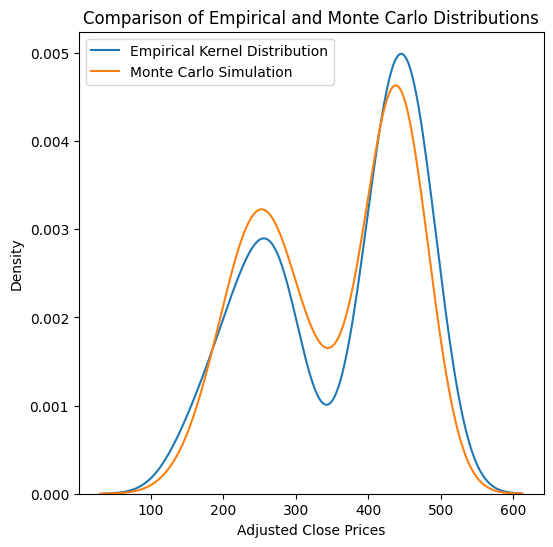

In [37]:
# Extract adjusted close prices
adj_close_prices = NVDA["Adj Close"].values
num_trading_days = len(adj_close_prices)  # number of trading days

# Calculate sample mean and standard deviation
sample_mean = np.mean(adj_close_prices)
sample_std = np.std(adj_close_prices)
print("SAMPLE MEAN", sample_mean)
print("SAMPLE STD", sample_std)

# Define parameters for the normal mixture
mu_1 = 254  # mean of the first component distribution
sigma_1 = 48  # standard deviation of the first component distribution
mu_2 = 438  # mean of the second component distribution
sigma_2 = 29  # standard deviation of the second component distribution
p = 0.48


def generate_empirical_dist(mu_1, sigma_1, mu_2, sigma_2, p, num_days):
    # Normal Mixture Simulation
    simulated_price = np.zeros(num_days - 1)
    for t in range(0, num_days - 1):
        p1 = mu_1 + sigma_1 * np.random.normal(0, 1, 1)
        p2 = mu_2 + sigma_2 * np.random.normal(0, 1, 1)
        u = np.random.uniform(0, 1, 1)
        simulated_price[t] = p1 * (u < p) + p2 * (u >= p)
    return simulated_price


# Monte Carlo Simulation
num_simulations = 1000
mc_sample_mean = np.zeros(num_simulations)
mc_aggregated = 0

for i in range(0, num_simulations):
    simulated_price = generate_empirical_dist(
        mu_1, sigma_1, mu_2, sigma_2, p, num_trading_days
    )
    mc_sample_mean[i] = np.mean(simulated_price)
    mc_aggregated += np.sort(simulated_price)

mc_aggregated = mc_aggregated / num_simulations
mc_sample_mean = np.sort(mc_sample_mean)
print(
    "confidence interval of Monte Carlo mean:", mc_sample_mean[25], mc_sample_mean[975]
)

# Visualization
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(data=adj_close_prices, ax=ax)  # Plot empirical distribution (blue line)
sns.kdeplot(data=mc_aggregated, ax=ax)  # Plot Monte Carlo simulation (orange line)
ax.legend(["Empirical Kernel Distribution", "Monte Carlo Simulation"])
plt.xlabel("Adjusted Close Prices")
plt.ylabel("Density")
plt.title("Comparison of Empirical and Monte Carlo Distributions")
plt.show()

## GARCH

<ipython-input-38-2f0c77cbfe0d>:40: OptimizeWarning: Unknown solver options: xtol
  estimated_params = minimize(GARCH, initial_params, method="BFGS", options={"xtol": 1e-8, "disp": True})
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -99.323057
         Iterations: 2
         Function evaluations: 130
         Gradient evaluations: 24


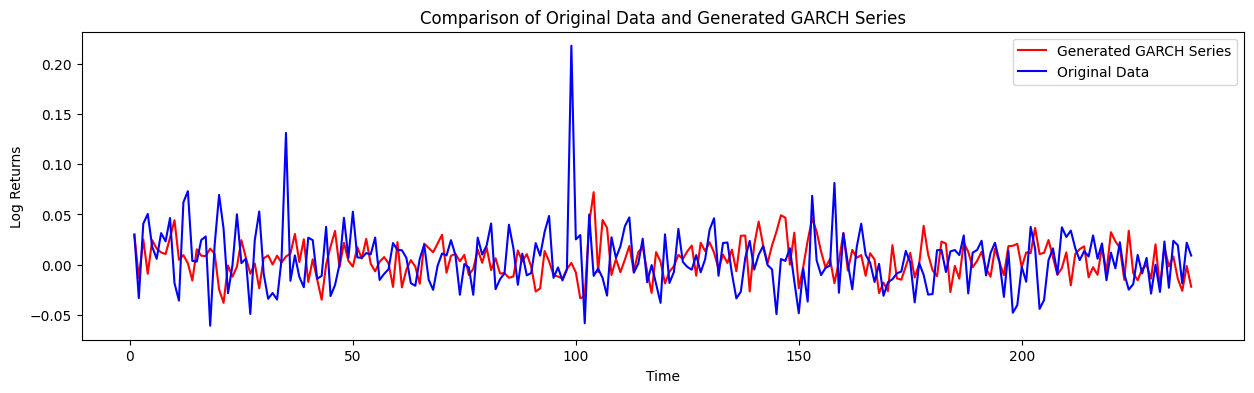

RMSE: 0.03


In [38]:
def GARCH_likelihood(param, Y):
    mu, omega, alpha, beta = param
    T = Y.shape[0]
    GARCH_Dens = np.zeros(T)
    sigma2 = np.zeros(T)
    F = np.zeros(T)
    v = np.zeros(T)
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t - 1] - mu) ** 2) + beta * (sigma2[t - 1])
        F[t] = Y[t] - mu - np.sqrt(sigma2[t]) * np.random.normal(0, 1, 1)
        v[t] = sigma2[t]
        GARCH_Dens[t] = (
            (1 / 2) * np.log(2 * np.pi)
            + (1 / 2) * np.log(v[t])
            + (1 / 2) * (F[t] / v[t])
        )
    Likelihood = np.sum(GARCH_Dens[1:-1])
    return Likelihood


def simulate_GARCH(params, Y0, T):
    mu, omega, alpha, beta = params
    Y = np.zeros(T)
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0] = 0.003
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t - 1] - mu) ** 2) + beta * (sigma2[t - 1])
        Y[t] = mu + np.sqrt(sigma2[t]) * np.random.normal(0, 1, 1)
    return Y


# Calculate log returns
log_returns = np.diff(np.log(NVDA["Adj Close"].values))
data_length = log_returns.size

# Initialize GARCH model parameters
initial_params = np.array([np.mean(log_returns), np.var(log_returns) / 4, 0.15, 0.2])

# Estimate GARCH parameters using optimization
estimated_params = minimize(
    GARCH, initial_params, method="BFGS", options={"xtol": 1e-8, "disp": True}
)

# Generate GARCH time series
generated_series = GARCH_PROD(estimated_params.x, log_returns[0], data_length)

# Create time vector
time_vector = np.linspace(1, data_length, data_length)

# Plot original data and generated GARCH time series
plt.figure(figsize=(15, 4))
# plt.plot(time_vector, generated_series, "r", time_vector, log_returns, "b")
plt.plot(time_vector, generated_series, "r", label="Generated GARCH Series")
plt.plot(time_vector, log_returns, "b", label="Original Data")
plt.xlabel("Time")
plt.ylabel("Log Returns")
plt.title("Comparison of Original Data and Generated GARCH Series")
plt.legend()
plt.show()

# Calculate and print RMSE
RMSE = np.sqrt(np.mean((generated_series - log_returns) ** 2))
print(f"RMSE: {RMSE:.2f}")